<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mura dataset
Currently for testing purposes, just part of dataset is used. Specifically XR_HUMERUS data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.backend as k
from google.colab import drive
drive.mount('/content/drive')
from keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
%matplotlib inline

PATH="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"

IMG_SIZE=(224,224)
BATCH_SIZE = 8

train_batches = ImageDataGenerator().flow_from_directory(
    PATH + 'train',      # this is the target directory
    target_size=IMG_SIZE,  # all images will be resized to 224*224
    batch_size=BATCH_SIZE,
)

valid_batches = ImageDataGenerator().flow_from_directory(
    PATH + 'valid',      # this is the target directory
    target_size=IMG_SIZE,  # all images will be resized to 224*224
    batch_size=BATCH_SIZE, 
)

print(train_batches.class_indices)
print(train_batches.class_indices)



Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Found 1272 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
{'train_negative': 0, 'train_positive': 1}
{'train_negative': 0, 'train_positive': 1}


## Functions
Next block contains definitions of function for following code.

In [0]:
def label_to_string(label):
  if(label[0] == 0):
    return "Negative"
  else:
    return "Positive"

def show_sample_images():
  images, labels = train_batches.next()
  plt.figure(figsize=(25,25))
  for i in range(BATCH_SIZE):
    plt.subplot(1,BATCH_SIZE,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(label_to_string(labels[i]))
    plt.imshow(images[i].astype('uint8'), cmap=plt.cm.binary)
  plt.show()

def prep_images():
  ...

def model_def():
  model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax'),
  ])
  return model

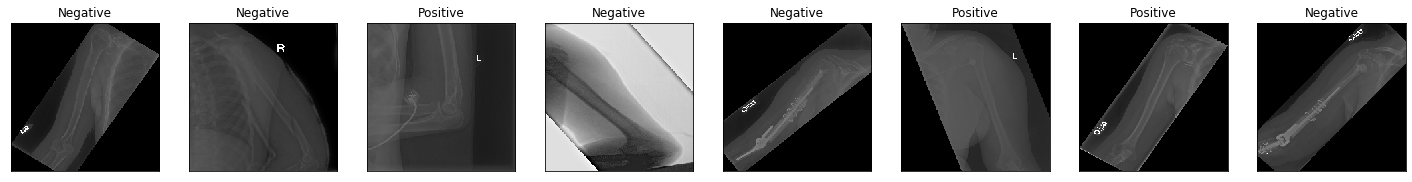

In [25]:
show_sample_images()

In [3]:
model = model_def()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [4]:
model.fit_generator(train_batches,
                    steps_per_epoch=62,
                    validation_data = valid_batches,
                    validation_steps = 62,
                    epochs = 5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





62/62 [==============================] - 284s 5s/step - loss: 7.4972 - acc: 0.5323 - val_loss: 7.0517 - val_acc: 0.5625
Epoch 2/5
62/62 [==============================] - 162s 3s/step - loss: 7.3653 - acc: 0.5423 - val_loss: 7.9941 - val_acc: 0.5040
Epoch 3/5
62/62 [==============================] - 114s 2s/step - loss: 7.3116 - acc: 0.5464 - val_loss: 7.6041 - val_acc: 0.5282
Epoch 4/5
62/62 [==============================] - 23s 371ms/step - loss: 8.0915 - acc: 0.4980 - val_loss: 7.8316 - val_acc: 0.5141
Epoch 5/5
62/62 [==============================] - 23s 366ms/step - loss: 7.3116 - acc: 0.5464 - val_loss: 8.1240 - val_acc: 0.4960
